# Fake Face Generator

## Masalah

Dengan Fake Face Generator ini, kita bisa membantu para UMKM untuk generate muka yang bisa digunakan untuk iklan atau marketing mereka.
Dengan generator ini, para UMKM tidak perlu membayar orang asli sehingga dapat menghemat pengeluaran para UMKM

## Import Libraries

In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm
import os,re,cv2
from keras.preprocessing.image import img_to_array

## Load data

In [2]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

SIZE = 128
_img = []
NoofIMGs = 10000

path = '/kaggle/input/face-mask-lite-dataset/without_mask'
files = sorted_alphanumeric(os.listdir(path))

for i in tqdm(files,total=NoofIMGs):    
    if i == str(NoofIMGs)+'.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(img, (SIZE, SIZE))
        
        img = (img - 127.5) / 127.5
       
        img = img.astype(float)
      
        
        _img.append(img_to_array(img))

100%|██████████| 10000/10000 [09:20<00:00, 17.83it/s]


## Visuailze

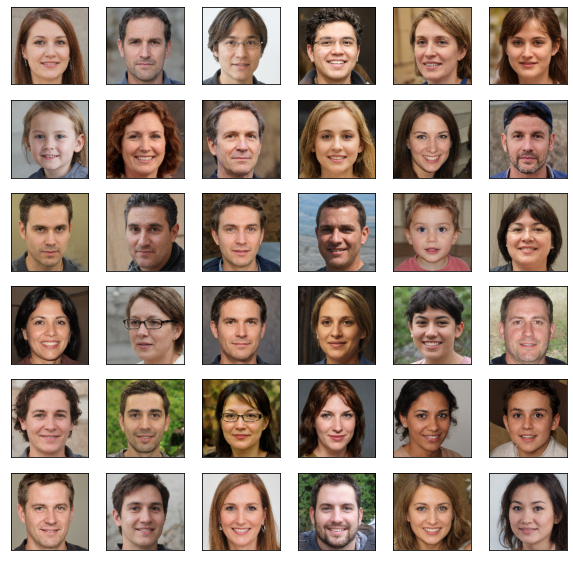

In [3]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)
    

In [4]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

latent_dim = 100

# Generator 

In [42]:
def Generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(latent_dim,)),
        layers.Reshape((8, 8, 512)),
        
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    ])
    return model


In [43]:
generator = Generator()
generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32768)             3276800   
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 16, 16, 256)       2097152   
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 32, 32, 128)       524288    
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 128)      

# Discriminator

In [44]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [45]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 128)       6144      
_________________________________________________________________
batch_normalization_31 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       262144    
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)      

### Let's plot image generated by generator before training

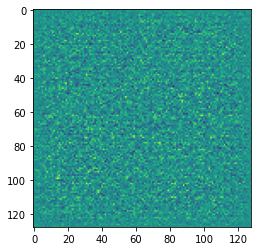

In [9]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

### Defining loss function and optimizer 

In [47]:
initial_learning_rate = 0.0001
decay_rate = 1e-8
decay_steps = 10000  

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, clipvalue=1.0)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [46]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

### Defining training steps

In [48]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

## function to plot generated images


In [49]:
def plot_generated_images(square = 5, epochs = 0):
    plt.figure(figsize = (10,10))
    for i in range(square * square):
        if epochs != 0:    
            if(i == square //2):
                plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2*0.8, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()

In [50]:
buffer_size = NoofIMGs + int(NoofIMGs/10)
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(np.array(_img)).shuffle(buffer_size).batch(batch_size)

In [51]:
def train(epochs, dataset, generator, discriminator, optimizer):
    for epoch in range(epochs):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0
        
        for images in tqdm(dataset, desc=f'Epoch {epoch + 1}/{epochs}', 
                           bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'):
            loss = train_steps(images)
            total_gen_loss += loss['gen loss']
            total_disc_loss += loss['disc loss']
            num_batches += 1
        
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Time: {np.round(time.time() - start, 3)} secs")
        print(f"Avg Generator Loss: {avg_gen_loss}")
        print(f"Avg Discriminator Loss: {avg_disc_loss}")
        print()

## Training

In [53]:
import time
train(50, dataset, generator, discriminator, optimizer)

Epoch 2/50:   0%|          | 0/625 [00:00<?]

Epoch 1/50
Time: 46.944 secs
Avg Generator Loss: 2.2305006980895996
Avg Discriminator Loss: 0.5190739631652832



Epoch 3/50:   0%|          | 0/625 [00:00<?]

Epoch 2/50
Time: 46.904 secs
Avg Generator Loss: 2.2373692989349365
Avg Discriminator Loss: 0.5169417262077332



Epoch 4/50:   0%|          | 0/625 [00:00<?]

Epoch 3/50
Time: 47.255 secs
Avg Generator Loss: 2.224172592163086
Avg Discriminator Loss: 0.5154032111167908



Epoch 5/50:   0%|          | 0/625 [00:00<?]

Epoch 4/50
Time: 47.005 secs
Avg Generator Loss: 2.2084550857543945
Avg Discriminator Loss: 0.5197015404701233



Epoch 6/50:   0%|          | 0/625 [00:00<?]

Epoch 5/50
Time: 46.987 secs
Avg Generator Loss: 2.2265334129333496
Avg Discriminator Loss: 0.5170543789863586



Epoch 7/50:   0%|          | 0/625 [00:00<?]

Epoch 6/50
Time: 46.937 secs
Avg Generator Loss: 2.2320876121520996
Avg Discriminator Loss: 0.5180985927581787



Epoch 8/50:   0%|          | 0/625 [00:00<?]

Epoch 7/50
Time: 47.039 secs
Avg Generator Loss: 2.2373929023742676
Avg Discriminator Loss: 0.517867386341095



Epoch 9/50:   0%|          | 0/625 [00:00<?]

Epoch 8/50
Time: 46.934 secs
Avg Generator Loss: 2.239264965057373
Avg Discriminator Loss: 0.5141860842704773



Epoch 10/50:   0%|          | 0/625 [00:00<?]

Epoch 9/50
Time: 47.136 secs
Avg Generator Loss: 2.227938175201416
Avg Discriminator Loss: 0.5137039422988892



Epoch 11/50:   0%|          | 0/625 [00:00<?]

Epoch 10/50
Time: 47.072 secs
Avg Generator Loss: 2.244931936264038
Avg Discriminator Loss: 0.5142043232917786



Epoch 12/50:   0%|          | 0/625 [00:00<?]

Epoch 11/50
Time: 47.072 secs
Avg Generator Loss: 2.232254981994629
Avg Discriminator Loss: 0.5140474438667297



Epoch 13/50:   0%|          | 0/625 [00:00<?]

Epoch 12/50
Time: 47.04 secs
Avg Generator Loss: 2.253359317779541
Avg Discriminator Loss: 0.5151925086975098



Epoch 14/50:   0%|          | 0/625 [00:00<?]

Epoch 13/50
Time: 46.96 secs
Avg Generator Loss: 2.23327374458313
Avg Discriminator Loss: 0.51558518409729



Epoch 15/50:   0%|          | 0/625 [00:00<?]

Epoch 14/50
Time: 46.862 secs
Avg Generator Loss: 2.247323513031006
Avg Discriminator Loss: 0.5130762457847595



Epoch 16/50:   0%|          | 0/625 [00:00<?]

Epoch 15/50
Time: 46.847 secs
Avg Generator Loss: 2.2426722049713135
Avg Discriminator Loss: 0.5149663090705872



Epoch 17/50:   0%|          | 0/625 [00:00<?]

Epoch 16/50
Time: 46.793 secs
Avg Generator Loss: 2.234532117843628
Avg Discriminator Loss: 0.5134630799293518



Epoch 18/50:   0%|          | 0/625 [00:00<?]

Epoch 17/50
Time: 46.869 secs
Avg Generator Loss: 2.2326016426086426
Avg Discriminator Loss: 0.5137608647346497



Epoch 19/50:   0%|          | 0/625 [00:00<?]

Epoch 18/50
Time: 46.741 secs
Avg Generator Loss: 2.2427475452423096
Avg Discriminator Loss: 0.5128438472747803



Epoch 20/50:   0%|          | 0/625 [00:00<?]

Epoch 19/50
Time: 46.739 secs
Avg Generator Loss: 2.2069907188415527
Avg Discriminator Loss: 0.5203514695167542



Epoch 21/50:   0%|          | 0/625 [00:00<?]

Epoch 20/50
Time: 46.625 secs
Avg Generator Loss: 2.2479214668273926
Avg Discriminator Loss: 0.5116952657699585



Epoch 22/50:   0%|          | 0/625 [00:00<?]

Epoch 21/50
Time: 46.792 secs
Avg Generator Loss: 2.2304439544677734
Avg Discriminator Loss: 0.5171294212341309



Epoch 23/50:   0%|          | 0/625 [00:00<?]

Epoch 22/50
Time: 46.813 secs
Avg Generator Loss: 2.242138147354126
Avg Discriminator Loss: 0.5123392343521118



Epoch 24/50:   0%|          | 0/625 [00:00<?]

Epoch 23/50
Time: 46.764 secs
Avg Generator Loss: 2.228349447250366
Avg Discriminator Loss: 0.5196961760520935



Epoch 25/50:   0%|          | 0/625 [00:00<?]

Epoch 24/50
Time: 46.753 secs
Avg Generator Loss: 2.2202696800231934
Avg Discriminator Loss: 0.5184448957443237



Epoch 26/50:   0%|          | 0/625 [00:00<?]

Epoch 25/50
Time: 46.748 secs
Avg Generator Loss: 2.231297492980957
Avg Discriminator Loss: 0.5175405144691467



Epoch 27/50:   0%|          | 0/625 [00:00<?]

Epoch 26/50
Time: 46.973 secs
Avg Generator Loss: 2.2427375316619873
Avg Discriminator Loss: 0.5162796974182129



Epoch 28/50:   0%|          | 0/625 [00:00<?]

Epoch 27/50
Time: 46.722 secs
Avg Generator Loss: 2.2082417011260986
Avg Discriminator Loss: 0.5221413373947144



Epoch 29/50:   0%|          | 0/625 [00:00<?]

Epoch 28/50
Time: 46.846 secs
Avg Generator Loss: 2.2234137058258057
Avg Discriminator Loss: 0.5138375163078308



Epoch 30/50:   0%|          | 0/625 [00:00<?]

Epoch 29/50
Time: 46.784 secs
Avg Generator Loss: 2.236349105834961
Avg Discriminator Loss: 0.5156470537185669



Epoch 31/50:   0%|          | 0/625 [00:00<?]

Epoch 30/50
Time: 46.97 secs
Avg Generator Loss: 2.2278871536254883
Avg Discriminator Loss: 0.5149929523468018



Epoch 32/50:   0%|          | 0/625 [00:00<?]

Epoch 31/50
Time: 46.776 secs
Avg Generator Loss: 2.2436208724975586
Avg Discriminator Loss: 0.5127004384994507



Epoch 33/50:   0%|          | 0/625 [00:00<?]

Epoch 32/50
Time: 46.794 secs
Avg Generator Loss: 2.2208592891693115
Avg Discriminator Loss: 0.5156888365745544



Epoch 34/50:   0%|          | 0/625 [00:00<?]

Epoch 33/50
Time: 46.837 secs
Avg Generator Loss: 2.2205440998077393
Avg Discriminator Loss: 0.5163946747779846



Epoch 35/50:   0%|          | 0/625 [00:00<?]

Epoch 34/50
Time: 46.911 secs
Avg Generator Loss: 2.2346930503845215
Avg Discriminator Loss: 0.5176708698272705



Epoch 36/50:   0%|          | 0/625 [00:00<?]

Epoch 35/50
Time: 46.816 secs
Avg Generator Loss: 2.2293198108673096
Avg Discriminator Loss: 0.5135110020637512



Epoch 37/50:   0%|          | 0/625 [00:00<?]

Epoch 36/50
Time: 46.935 secs
Avg Generator Loss: 2.224194288253784
Avg Discriminator Loss: 0.5173086524009705



Epoch 38/50:   0%|          | 0/625 [00:00<?]

Epoch 37/50
Time: 46.847 secs
Avg Generator Loss: 2.223079204559326
Avg Discriminator Loss: 0.5181959271430969



Epoch 39/50:   0%|          | 0/625 [00:00<?]

Epoch 38/50
Time: 46.803 secs
Avg Generator Loss: 2.2319047451019287
Avg Discriminator Loss: 0.5135694742202759



Epoch 40/50:   0%|          | 0/625 [00:00<?]

Epoch 39/50
Time: 46.841 secs
Avg Generator Loss: 2.2254414558410645
Avg Discriminator Loss: 0.5183083415031433



Epoch 41/50:   0%|          | 0/625 [00:00<?]

Epoch 40/50
Time: 46.714 secs
Avg Generator Loss: 2.2429745197296143
Avg Discriminator Loss: 0.5153839588165283



Epoch 42/50:   0%|          | 0/625 [00:00<?]

Epoch 41/50
Time: 46.917 secs
Avg Generator Loss: 2.227489709854126
Avg Discriminator Loss: 0.5207070112228394



Epoch 44/50:   0%|          | 0/625 [00:00<?]

Epoch 43/50
Time: 46.886 secs
Avg Generator Loss: 2.2369813919067383
Avg Discriminator Loss: 0.5161658525466919



Epoch 45/50:   0%|          | 0/625 [00:00<?]

Epoch 44/50
Time: 46.741 secs
Avg Generator Loss: 2.2314844131469727
Avg Discriminator Loss: 0.5154541730880737



Epoch 46/50:   0%|          | 0/625 [00:00<?]

Epoch 45/50
Time: 46.781 secs
Avg Generator Loss: 2.2236382961273193
Avg Discriminator Loss: 0.5173969864845276



Epoch 47/50:   0%|          | 0/625 [00:00<?]

Epoch 46/50
Time: 46.748 secs
Avg Generator Loss: 2.240159273147583
Avg Discriminator Loss: 0.5173927545547485



Epoch 48/50:   0%|          | 0/625 [00:00<?]

Epoch 47/50
Time: 46.688 secs
Avg Generator Loss: 2.2284348011016846
Avg Discriminator Loss: 0.5182291865348816



Epoch 49/50:   0%|          | 0/625 [00:00<?]

Epoch 48/50
Time: 46.751 secs
Avg Generator Loss: 2.233220100402832
Avg Discriminator Loss: 0.5151574015617371



Epoch 50/50:   0%|          | 0/625 [00:00<?]

Epoch 49/50
Time: 46.797 secs
Avg Generator Loss: 2.2498831748962402
Avg Discriminator Loss: 0.5147406458854675



Epoch 50/50: 100%|██████████| 625/625 [00:46<00:00]

Epoch 50/50
Time: 46.682 secs
Avg Generator Loss: 2.2418272495269775
Avg Discriminator Loss: 0.5138344168663025



# Some Generated Images


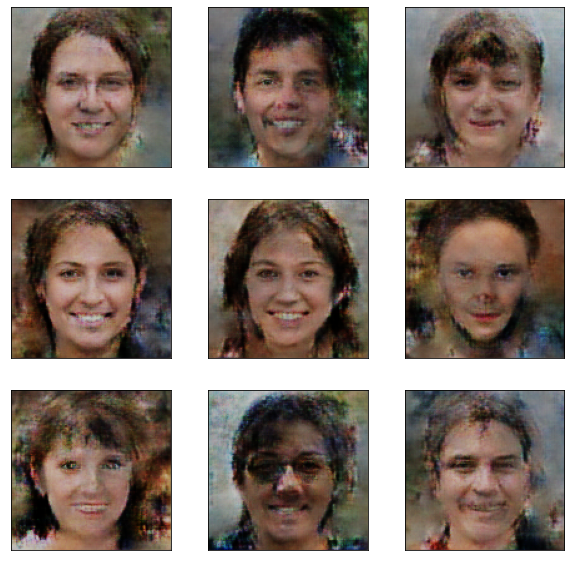

In [97]:
plot_generated_images(3)

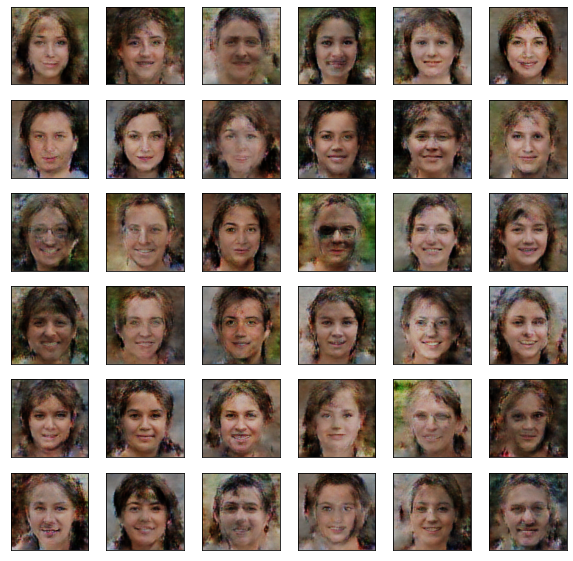

In [59]:
plot_generated_images(6)

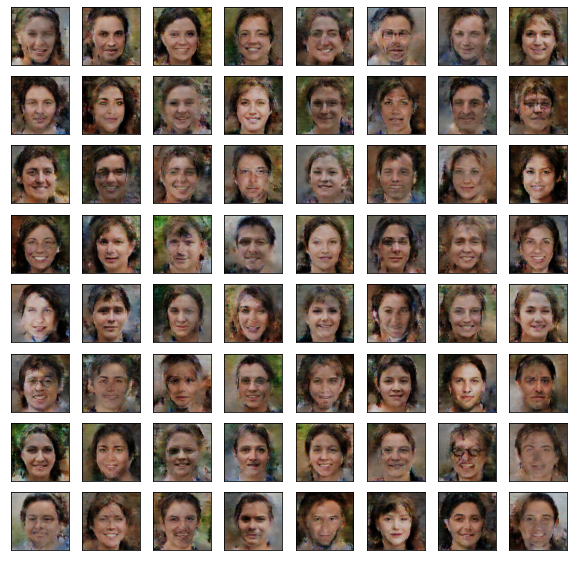

In [60]:
plot_generated_images(8)

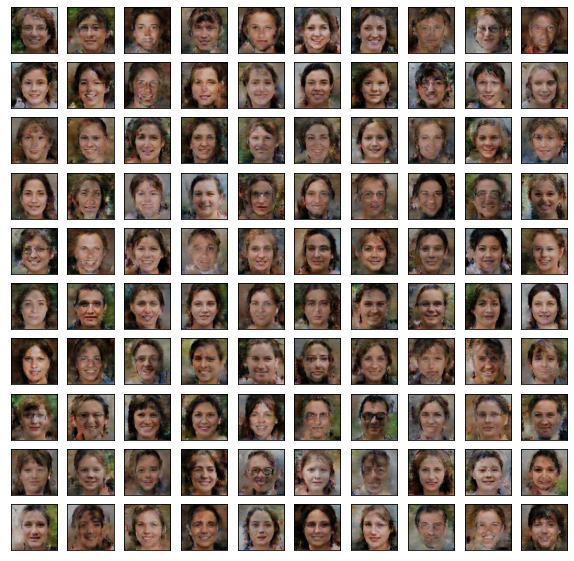

In [61]:
plot_generated_images(10)

In [21]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")